# Introduction

This notebook is the final project of the data science course in the College of Management.
Written By: 
* Itay Gabbay
* Matan Perelmuter
* Amit Ben Ami
* Danielle Zror
* Gal Wurmbrand.

## Data
The Hotels dataset is a collection of snapshots of prices from several NYC Hotels, taken between 2015-2016

Now, Let's import the necessary libraries and manipulate the data.
Note that we also create new columns like DayDiff and calculating the discount value and percentage from the original price.

In [1]:
# Imports
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# pandas
import pandas as pd
import numpy as np
from datetime import date

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

hotels_df = pd.read_csv("./input/hotels_data.csv")

hotels_df.head()

# Converting to date
hotels_df["Snapshot Date"] = pd.to_datetime(hotels_df["Snapshot Date"])#, format='%m-/%d-/%y %-H:%M')
hotels_df["Checkin Date"] = pd.to_datetime(hotels_df["Checkin Date"])#, format='%m-/%d-/%y %H-:%M')

hotels_df["DayDiff"] = (hotels_df["Checkin Date"].sub(hotels_df["Snapshot Date"], axis=0)).apply(lambda x: x.days)
hotels_df["WeekDay"] = hotels_df["Checkin Date"].apply(lambda x: x.strftime('%a'))
hotels_df["DiscountDiff"] = hotels_df["Original Price"] - hotels_df["Discount Price"]
hotels_df["DiscountPerc"] = (hotels_df["DiscountDiff"]/hotels_df["Original Price"]) * 100



##### Let's explore our converted dataset, and save it to a new csv file

In [2]:
print(hotels_df.info())
print('_'*80)
print (hotels_df.describe())
print('_'*80)
print(hotels_df.head())

hotels_df.to_csv("./input/Hotels_data_Changed.csv", encoding = "utf8")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187848 entries, 0 to 187847
Data columns (total 14 columns):
Snapshot ID        187848 non-null int64
Snapshot Date      187848 non-null datetime64[ns]
Checkin Date       187848 non-null datetime64[ns]
Days               187848 non-null int64
Original Price     187848 non-null int64
Discount Price     187848 non-null int64
Discount Code      187848 non-null int64
Available Rooms    187848 non-null int64
Hotel Name         187848 non-null object
Hotel Stars        187848 non-null int64
DayDiff            187848 non-null int64
WeekDay            187848 non-null object
DiscountDiff       187848 non-null int64
DiscountPerc       187848 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(9), object(2)
memory usage: 20.1+ MB
None
________________________________________________________________________________
         Snapshot ID      Days  Original Price  Discount Price  Discount Code  \
count  187848.000000  187848.0   187848.0000

### Data Exploration

We need to remember that we want to predict the discount code that will give us the max discount.

Let's investigate the correlation between the different features, and the required predicted column - the discount code

In [3]:
# Here will be data exploration
corr_df = hotels_df
corr_df["Hotel ID"] = corr_df["Hotel Name"].factorize()[0]
corr_df["Checkin Date Ordinal"] = pd.to_datetime(corr_df["Checkin Date"]).apply(lambda x: x.toordinal())
corr_df["Snapshot Date Ordinal"] = pd.to_datetime(corr_df["Snapshot Date"]).apply(lambda x: x.toordinal())

corr_df["WeekDayNum"] = corr_df["WeekDay"].factorize()[0]
print (corr_df.corr()["DiscountPerc"])

Snapshot ID              0.026398
Days                          NaN
Original Price          -0.151366
Discount Price          -0.258325
Discount Code           -0.036223
Available Rooms         -0.092789
Hotel Stars             -0.090960
DayDiff                 -0.018199
DiscountDiff             0.672048
DiscountPerc             1.000000
Hotel ID                -0.076962
Checkin Date Ordinal     0.166905
Snapshot Date Ordinal    0.172947
WeekDayNum              -0.054560
Name: DiscountPerc, dtype: float64


As we can see, we don't have strong linear correlation between the features to the discount percentage.
Thus, The relation is not linear.

We'll try to find a correlation between the maximum discount for each Week day, Snapshot Date, Check in Date, The Difference between Snapshot date and Checkin in days, and the hotel name

In [4]:
hotels_formatted = pd.read_csv("./input/Hotels_data_Changed.csv", encoding = "utf8")

maxDiscount = hotels_formatted.groupby(["WeekDay", "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name"])["DiscountPerc"].max()

maxDiscount = maxDiscount.to_frame().reset_index()
mergedResult = pd.merge(maxDiscount, hotels_formatted, left_on=['WeekDay', "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name", "DiscountPerc"],
                        right_on=['WeekDay', "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name", "DiscountPerc"])

mergedResult[['WeekDay', "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name", "Discount Code"]].to_csv("./input/max_discounts.csv", encoding="utf8")

Let's try to see if we have a correlation between the Weekday and the maximum discount code

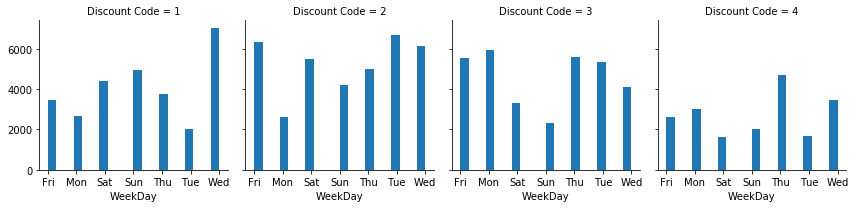

In [5]:
g = sns.FacetGrid(mergedResult, col='Discount Code')
g.map(plt.hist, 'WeekDay', bins=20)

We can see that discount code 4 is the most least used in each day, and on average, in the middle of the week (Tue, Wed) Discount codes 1&2 are more used than 3. Not enough information though.

Let's check for a total correlation between the columns.

In [6]:
# Here will be data exploration
corr_df = mergedResult
corr_df["Hotel ID"] = corr_df["Hotel Name"].factorize()[0]
corr_df["Checkin Date Ordinal"] = pd.to_datetime(corr_df["Checkin Date"]).apply(lambda x: x.toordinal())
corr_df["Snapshot Date Ordinal"] = pd.to_datetime(corr_df["Snapshot Date"]).apply(lambda x: x.toordinal())

corr_df["WeekDayNum"] = corr_df["WeekDay"].factorize()[0]
print (corr_df.corr()["DiscountPerc"])

DayDiff                 -0.014849
DiscountPerc             1.000000
Unnamed: 0               0.146411
Snapshot ID              0.084118
Days                          NaN
Original Price          -0.114407
Discount Price          -0.233243
Discount Code           -0.027188
Available Rooms         -0.082800
Hotel Stars             -0.075999
DiscountDiff             0.680349
Hotel ID                 0.017336
Checkin Date Ordinal     0.169321
Snapshot Date Ordinal    0.174770
WeekDayNum               0.057380
Name: DiscountPerc, dtype: float64


We can see a really bad linear correlation between the columns...

### Normalization
Now we will normalize the data for the decision tree algorithm.
Every categorical feature will become a number using factorize, and we will convert the dates features to ordinal dates, so the decision tree will be able to split up the features and calculate the IG

In [7]:
from sklearn import metrics
from sklearn.cross_validation import train_test_split

raw_data = pd.read_csv("./input/max_discounts.csv")

raw_data["Hotel ID"] = raw_data["Hotel Name"].factorize()[0]
raw_data["Snapshot Date Ordinal"] = pd.to_datetime(raw_data["Snapshot Date"]).apply(lambda x: x.toordinal())
raw_data["Checkin Date Ordinal"] = pd.to_datetime(raw_data["Checkin Date"]).apply(lambda x: x.toordinal())
raw_data["Weekday ID"] = raw_data["WeekDay"].factorize()[0]

X_train, X_test, Y_train, Y_test = train_test_split(raw_data[["Weekday ID", "Snapshot Date Ordinal", "Checkin Date Ordinal", "DayDiff", "Hotel ID"]], raw_data[["Discount Code"]])

c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's see the structure of the training data

In [8]:
print (X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86937 entries, 107226 to 37231
Data columns (total 5 columns):
Weekday ID               86937 non-null int64
Snapshot Date Ordinal    86937 non-null int64
Checkin Date Ordinal     86937 non-null int64
DayDiff                  86937 non-null int64
Hotel ID                 86937 non-null int64
dtypes: int64(5)
memory usage: 4.0 MB
None


### Decision Tree model

Now, after we formatted and normalized the data, we will try to fit a decision tree model for it.
Let's check the accuracy of the prediction!

In [9]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

treeModel = DecisionTreeClassifier()
treeModel.fit(X_train, Y_train)

treePredicted = treeModel.predict(X_test)
treeExpected = Y_test

print ("Accuracy:" + str(metrics.accuracy_score(treeExpected, treePredicted)))
print ('_'*80)
cnf_matrix = confusion_matrix(treeExpected, treePredicted)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print ("Confusion Matrix:")
print(cnf_matrix)

Accuracy:0.722212636737
________________________________________________________________________________
Confusion Matrix:
[[ 0.72911711  0.14565552  0.07233804  0.05288932]
 [ 0.11702951  0.73201459  0.11061996  0.04033595]
 [ 0.09015674  0.12739812  0.72476489  0.05768025]
 [ 0.12292013  0.08985025  0.09796173  0.68926789]]


73%. Not bad..

### ROC Curve

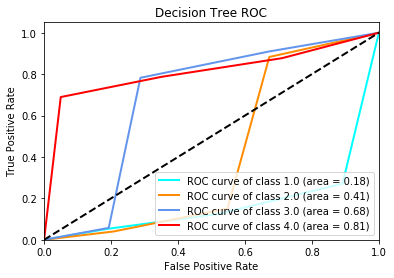

In [10]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(0, 4):
    fpr[i], tpr[i], _ = roc_curve(treeExpected, treePredicted, pos_label=(int(i)+1))
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0, 4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(0,4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(0,4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1.0, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="lower right")
plt.show()

### Naive Bayes model
We will try to fit a naive bayes clasiffier to our data.

For naive bayes, we will normalize the data to a different structure.
We will normalize the data to a 0&1 binary table: Each hotel will become a column, and each snapshot date and checkin date will also become a separate column. we do that in order to improve the accuracy of the ML model we will run shortly.

In [11]:
raw_data_nb = pd.read_csv("./input/max_discounts.csv")
hotels = pd.get_dummies(raw_data_nb["Hotel Name"]).add_prefix('Hotel_Name_')
raw_data_nb = raw_data_nb.join(hotels)
raw_data_nb = raw_data_nb.drop('Hotel Name', axis=1)

snapshots = pd.get_dummies(raw_data_nb["Snapshot Date"]).add_prefix('Snapshot_date_')
checkins = pd.get_dummies(raw_data_nb["Checkin Date"]).add_prefix('Checkin_date_')
raw_data_nb = raw_data_nb.join(snapshots).join(checkins)
raw_data_nb["Weekday ID"] = raw_data_nb["WeekDay"].factorize()[0]
weekdays = pd.get_dummies(raw_data_nb["Weekday ID"]).add_prefix('Weekday_')
raw_data_nb = raw_data_nb.join(weekdays)
raw_data_nb = raw_data_nb.drop('Weekday ID', axis=1)
# raw_data.to_csv('raw.csv', index = False)
X = raw_data_nb.drop(["Snapshot Date", "Checkin Date", "WeekDay", "Discount Code"], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, raw_data_nb[["Discount Code"]])

Let's see the structure of the training data

In [12]:
print (X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86937 entries, 61890 to 111121
Columns: 916 entries, Unnamed: 0 to Weekday_6
dtypes: int64(2), uint8(914)
memory usage: 77.8 MB
None


In [13]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

model = MultinomialNB()
model.fit(X_train, Y_train.values.ravel())

NBpredicted = model.predict(X_test)
NBexpected = Y_test

print (metrics.accuracy_score(NBexpected, NBpredicted))

cnf_matrix = confusion_matrix(NBexpected, NBpredicted)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print ('_'*80)
print ("Confusion Matrix:")
print (cnf_matrix)

0.380965526761
________________________________________________________________________________
Confusion Matrix:
[[ 0.47312287  0.19468146  0.24914676  0.08304892]
 [ 0.28240539  0.3368856   0.32579382  0.05491518]
 [ 0.2130862   0.25687275  0.4592611   0.07077995]
 [ 0.32109508  0.15152801  0.33149406  0.19588285]]


We got 40% accuracy. We can assume that this is not the best model to predict this type of data.
The bad correlation between the columns can explain it.

### ROC Curve

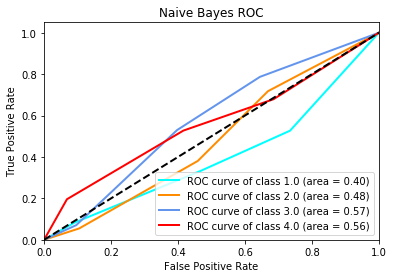

In [14]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(0, 4):
    fpr[i], tpr[i], _ = roc_curve(NBexpected, NBpredicted, pos_label=(int(i)+1))
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0, 4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(0,4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(0,4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1.0, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC')
plt.legend(loc="lower right")
plt.show()

### Explanation

We can see the difference between the 2 algorithms. The decision tree gave us better results (about 73% accuracy) compared to the naive bayes that gave 40% accuracy. 
Moreover, we can learn from the ROC curve of the decision tree that it predicts really well the 4th dicount code, but has a high false positive rate for the 1st discount code.

We used the Multinomial Naive Bayes as a classifier because the data is not normally distributed. We have less of the 4th discount code than the others. We can see that it's accuracy is not really good. In it's ROC curve (and the AUC 


## Clustering

Now, We will try to cluster the top 150 hotels in the top 40 checkin dates using hierarchical clustering.

First we will order by the hotels count and take the top 150.
Then, again we will sort by checkin dates and will take the top 40 Checkin dates.

In [15]:
# Clustring

ordered_hotels = pd.read_csv("./input/Hotels_data_Changed.csv", encoding = "utf8")
hotel_count = ordered_hotels.groupby("Hotel Name").size().reset_index(name="counts")
hotel_count = hotel_count.sort_values("counts", ascending=False).head(150)[["Hotel Name"]]
ordered_hotels = pd.merge(left = hotel_count, right=ordered_hotels,left_on="Hotel Name", right_on="Hotel Name")
date_count = ordered_hotels.groupby("Checkin Date").size().reset_index(name="counts")
date_count = date_count.sort_values("counts", ascending=False).head(40)[["Checkin Date"]]
ordered_hotels = pd.merge(left=date_count, right=ordered_hotels, left_on="Checkin Date", right_on="Checkin Date")

print(ordered_hotels.describe())



          Unnamed: 0    Snapshot ID     Days  Original Price  Discount Price  \
count   60423.000000   60423.000000  60423.0    60423.000000    60423.000000   
mean    81414.434768     350.668471      5.0     1883.680469     1723.842378   
std     44612.541210    1736.060796      0.0      994.130362      936.201756   
min         2.000000       1.000000      5.0      372.000000      332.000000   
25%     46117.500000     182.000000      5.0     1260.000000     1138.000000   
50%     83807.000000     435.000000      5.0     1688.000000     1542.000000   
75%    109761.500000     472.000000      5.0     2179.000000     1976.500000   
max    187841.000000  417419.000000      5.0    10625.000000    10500.000000   

       Discount Code  Available Rooms   Hotel Stars       DayDiff  \
count   60423.000000     60423.000000  60423.000000  60423.000000   
mean        2.465468        16.063933      3.950284     17.699618   
std         1.002378        42.610211      0.792335      9.804967   
min

### Data Preprocessing

We will take the dataframe and process it in order to fit it to the hierarchical clustering algorithm.
First, we will choose the minimal discount price for each hotel for each checkin date.
After that, we will pivot the df that each row will represent a hotel, with 160 columns, each represent a combination of a checkin date and a discount code (40 * 4 = 160).
Then, we will normalize the discount price for each hotel using a min max scaler - for a range of 0-100.
For every empty value, we will fill -1.

Finally, we will save that df to a csv.

In [16]:
from sklearn import preprocessing

#Creating the clustered data frame
min_price = ordered_hotels.groupby(["Checkin Date", "Hotel Name", "Discount Code"])["Discount Price"].min()

min_price = min_price.to_frame().reset_index()

# Normalization
def normalize(x):
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 100))
    return pd.Series(min_max_scaler.fit_transform(x.values), index=x.index)

hotelPrices = min_price.groupby("Hotel Name")["Discount Price"]
# hotelPrices = hote
# print (min_price.loc[min_price["Hotel Name"] == "Hampton Inn Times Square North"].sort_values("Discount Price", ascending=False))
hotelPrices = hotelPrices.apply(normalize)
min_price["Discount Price"] = hotelPrices
# print (min_price.loc[min_price["Hotel Name"] == "Hampton Inn Times Square North"].sort_values("Discount Price", ascending=False))
pivot = pd.pivot_table(min_price, values='Discount Price', columns=["Checkin Date", "Discount Code"], index=["Hotel Name"])
pivot = pivot.fillna(-1)
pivot.to_csv("./input/datatocluster.csv", encoding = "utf8")

c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sam

c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and wil

## Hierarchical Clustering algorithm

Now, we will run hierarchical clustering on the processes data, and try to figure out which hotels are similar in the discount policies.

We will do that using scipy and the output will be a dendogram of the clusters.

First it calculates the linkage matrix between the rows. The structure of the matrix is 149 * 4 - and each row represents a connection between to clusters: the first column is the first cluster index, the second column is second cluster index, the third column is the distance between the clusters, and the fourth is the number of clusters in this new cluster.

Let's check different distance methods to determine which is the best for us to use:


In [17]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

ward = linkage(pivot, 'ward')
wardc, coph_dists = cophenet(ward, pdist(pivot))
complete = linkage(pivot, 'complete')
completec, coph_dists = cophenet(complete, pdist(pivot))
single = linkage(pivot, 'single')
singlec, coph_dists = cophenet(single, pdist(pivot))
average = linkage(pivot, 'average')
averagec, coph_dists = cophenet(average, pdist(pivot))
weighted = linkage(pivot, 'weighted')
weightedc, coph_dists = cophenet(weighted, pdist(pivot))

print('Ward:' + str(wardc))
print('Complete:' + str(completec))
print('Single:' + str(singlec))
print('Average:' + str(averagec))
print('Weighted:' + str(weightedc))

Ward:0.629186832394
Complete:0.793266849953
Single:0.834549202662
Average:0.880087929937
Weighted:0.803590421006


As we can see, the average distance method, which is decribed by the average of distances between all the features from cluster a to cluster b, gives us the best Cophenetic Correlation Coefficient (The more closer to 1 - the better).
Which means it highly preserves the original distances between the clusters.

Now, we will draw a dendogram of the average linkage matrix:


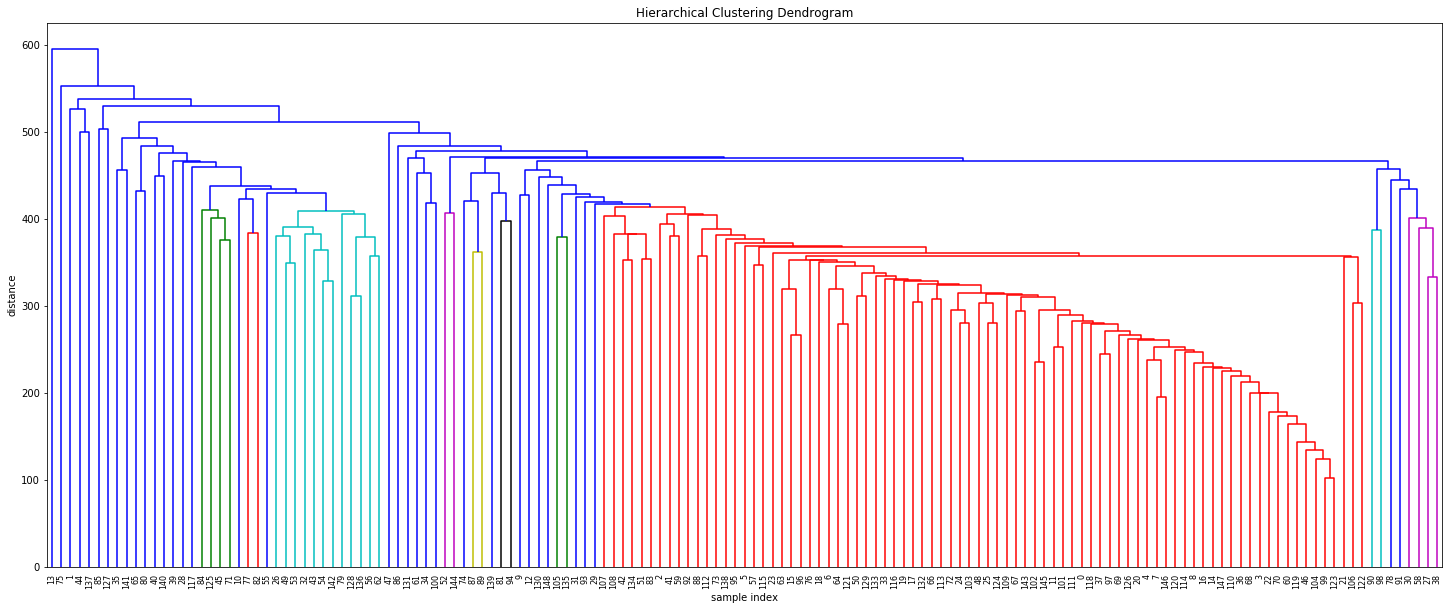

In [18]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    average,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=150,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()


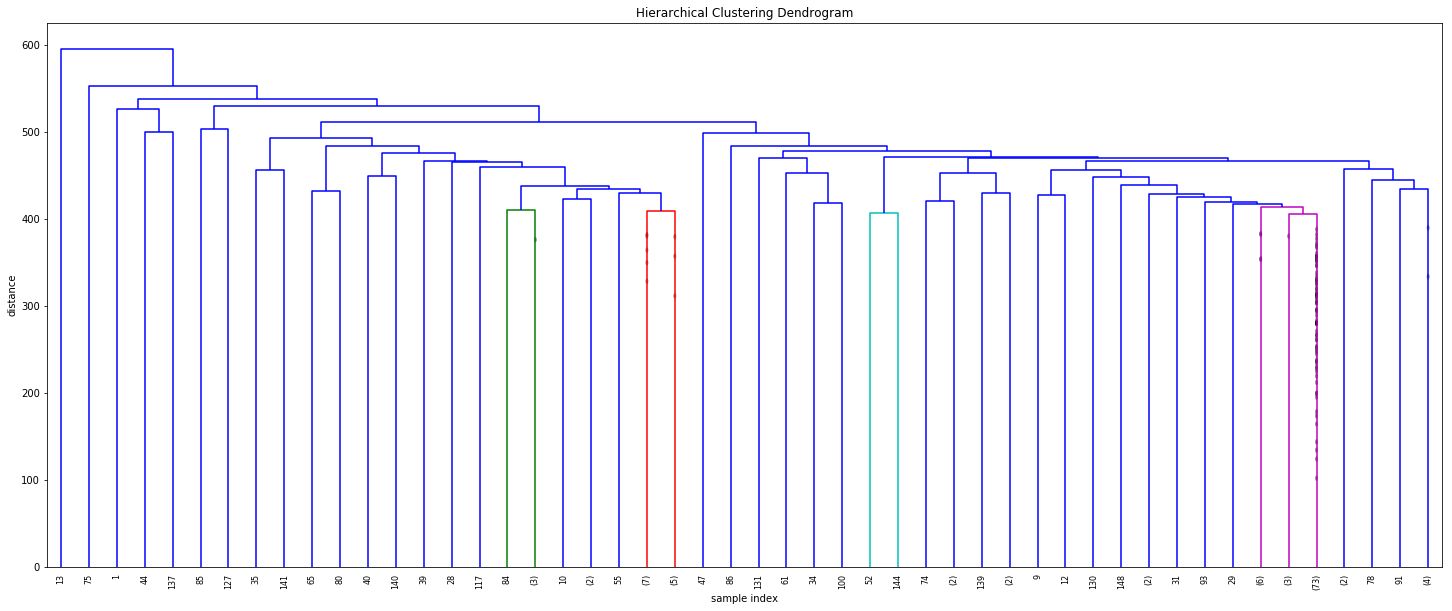

In [19]:
# calculate top 50 dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    average,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()